"Home Credit Default Risk" project with automatic feature engineering library featuretools
=======
This project is from the kaggle competition https://www.kaggle.com/c/home-credit-default-risk/overview and is a good practice to deal with large relational database. Doing feature engineering manually in this kind of datasets is possible but very exhausting. The usage of the automatic feature engineering library featuretools ( https://docs.featuretools.com/en/stable/ ) can really save our life. Before using this library, we still need to do exploratory data analysis (EDA) in order to understand these datasets (at least the main table) more. The understanding of the data can help us to do better data preprocessing before feature engineering. This EDA process is done in the seperated file Home_Credit_Default_Risk_app.ipynb.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb
import pickle
import re

import featuretools as ft
import featuretools.variable_types as vtypes

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
cash = pd.read_csv('POS_CASH_balance.csv')
credit = pd.read_csv('credit_card_balance.csv')
previous = pd.read_csv('previous_application.csv')
installments = pd.read_csv('installments_payments.csv')

In [3]:
print('app_train',app_train.shape)
print('app_test',app_test.shape)

app_train (307511, 122)
app_test (48744, 121)


In [4]:
app = app_train.append(app_test, ignore_index = True, sort = True)

In [5]:
print('app',app.shape)
print('bureau',bureau.shape)
print('bureau_balance',bureau_balance.shape)
print('cash',cash.shape)
print('credit',credit.shape)
print('previous',previous.shape)
print('installments',installments.shape)

app (356255, 122)
bureau (1716428, 17)
bureau_balance (27299925, 3)
cash (10001358, 8)
credit (3840312, 23)
previous (1670214, 37)
installments (13605401, 8)


In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

There are about 8% default vs 92% default. This dataset is imbalance data, so accuracy is not a good evaluation metric here. In this competition, the area under the ROC curve will be used as the performance measure. 

In [183]:
cash.head()

,cash_index,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1,1715348,367990,-33,36.0,35.0,Active,0,0
2,2,1784872,397406,-32,12.0,9.0,Active,0,0
3,3,1903291,269225,-35,48.0,42.0,Active,0,0
4,4,2341044,334279,-35,36.0,35.0,Active,0,0


## Data exploratory analysis
In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. We can identify outliers, trends and patterns in data. There are more in Home_Credit_Default_Risk_app.ipynb.

In [9]:
categorical = [var for var in app.columns if app[var].dtype=='O']
numerical = [var for var in app.columns if app[var].dtype!='O']
print("There are ", len(categorical), " categorical features and ", len(numerical)," numerical features")

There are  16  categorical features and  106  numerical features


In [13]:
for col in numerical:
    print(col,'# of values: ', len(app[col].unique()) )

AMT_ANNUITY # of values:  14167
AMT_CREDIT # of values:  6480
AMT_GOODS_PRICE # of values:  1292
AMT_INCOME_TOTAL # of values:  2741
AMT_REQ_CREDIT_BUREAU_DAY # of values:  10
AMT_REQ_CREDIT_BUREAU_HOUR # of values:  6
AMT_REQ_CREDIT_BUREAU_MON # of values:  25
AMT_REQ_CREDIT_BUREAU_QRT # of values:  12
AMT_REQ_CREDIT_BUREAU_WEEK # of values:  10
AMT_REQ_CREDIT_BUREAU_YEAR # of values:  26
APARTMENTS_AVG # of values:  2392
APARTMENTS_MEDI # of values:  1164
APARTMENTS_MODE # of values:  771
BASEMENTAREA_AVG # of values:  3832
BASEMENTAREA_MEDI # of values:  3822
BASEMENTAREA_MODE # of values:  3892
CNT_CHILDREN # of values:  16
CNT_FAM_MEMBERS # of values:  19
COMMONAREA_AVG # of values:  3272
COMMONAREA_MEDI # of values:  3290
COMMONAREA_MODE # of values:  3216
DAYS_BIRTH # of values:  17467
DAYS_EMPLOYED # of values:  12896
DAYS_ID_PUBLISH # of values:  6224
DAYS_LAST_PHONE_CHANGE # of values:  3847
DAYS_REGISTRATION # of values:  15898
DEF_30_CNT_SOCIAL_CIRCLE # of values:  11
DEF_6

In [14]:
# First we check the distribution of and the correlation between continous variables.
# Here we define the unique number larger than 1000 as the continous variables.
continuous=[]
for col in numerical:
    if (len( app[col].unique() ) > 10000):
        continuous.append(col)
        print(col,'# of values: ', len(app[col].unique()) )

AMT_ANNUITY # of values:  14167
DAYS_BIRTH # of values:  17467
DAYS_EMPLOYED # of values:  12896
DAYS_REGISTRATION # of values:  15898
EXT_SOURCE_1 # of values:  134316
EXT_SOURCE_2 # of values:  127158
SK_ID_CURR # of values:  356255


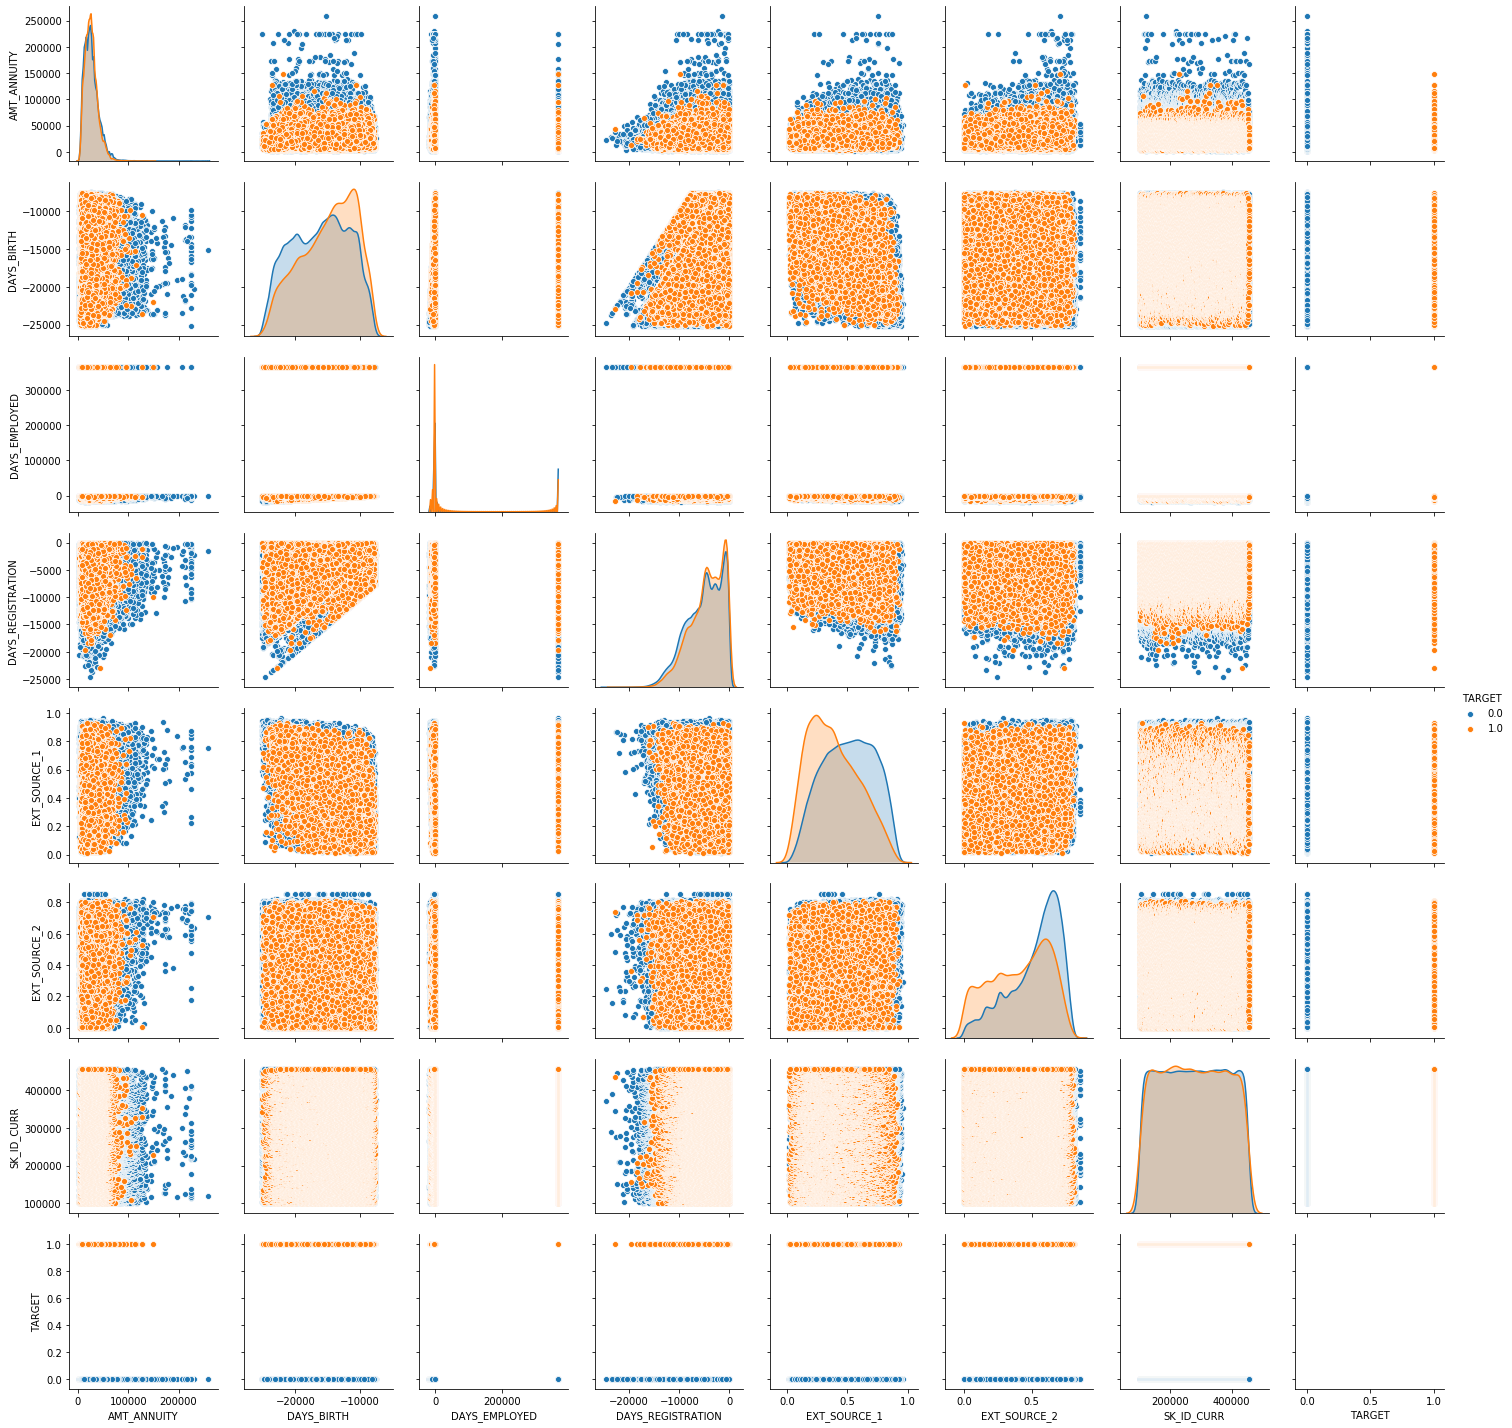

In [15]:
sns.pairplot( app[continuous+['TARGET']], hue='TARGET' )

From the above polot, we realize that the feature "DAYS_EMPLOYED" looks strange because there is outlier at very large number (more than 300000 days => more than 100 years)...Apparently, this is anomalies from data. We must check whether there is the same problem in other "days"-like features

In [18]:
print( len( app[app['DAYS_EMPLOYED']>300000]['DAYS_EMPLOYED'].unique() ) )

1


In [19]:
app[app['DAYS_EMPLOYED']>300000]['DAYS_EMPLOYED'].unique()

array([365243])

In [20]:
# Get the possible variables which represent days
def get_col_days( df ):
    pattern = re.compile(r'days',re.IGNORECASE)
    col_days = []
    for col in df:
        if( pattern.search(col) != None):
            col_days.append( col )
    return col_days

In [25]:
col_days_app = get_col_days( app )
col_days_bureau = get_col_days( bureau )
col_days_bureau_balance = get_col_days( bureau_balance )
col_days_cash = get_col_days( cash )
col_days_credit = get_col_days( credit )
col_days_previous = get_col_days( previous )
col_days_installments = get_col_days( installments )

In [26]:
print(col_days_app)
print(col_days_bureau)
print(col_days_bureau_balance)
print(col_days_cash)
print(col_days_credit)
print(col_days_previous)
print(col_days_installments)

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION']
['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']
[]
[]
[]
['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1df54420f0>,
      dtype=object)

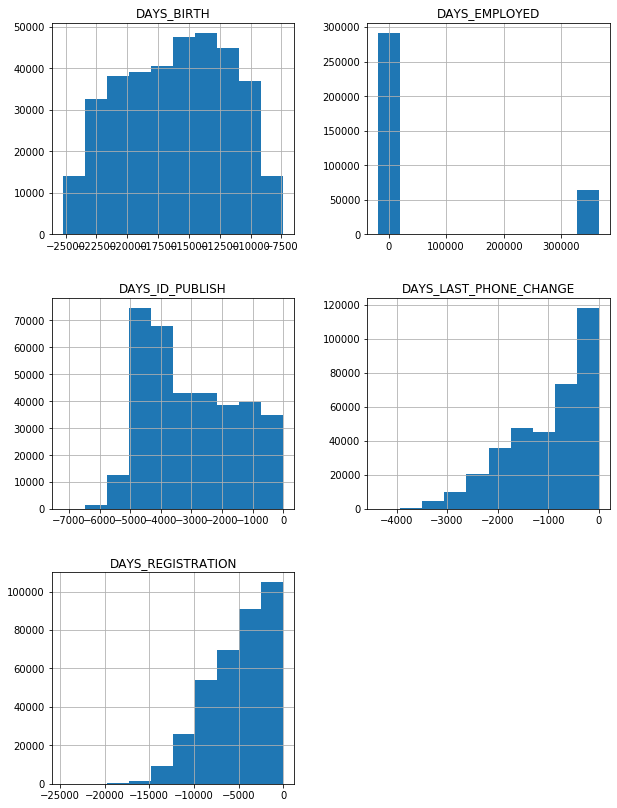

In [24]:
app[col_days_app].hist(figsize=(10,14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1de6f80780>,
      dtype=object)

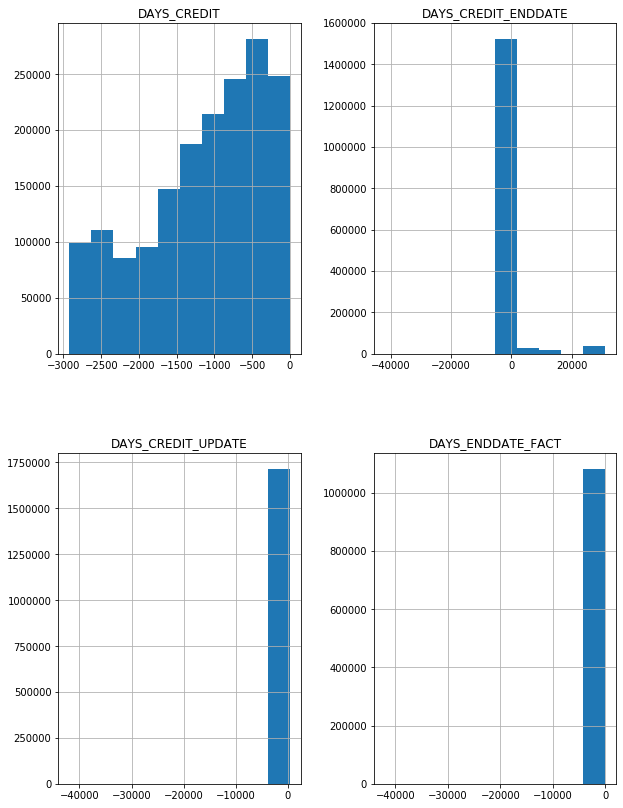

In [28]:
bureau[col_days_bureau].hist(figsize=(10,14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1df562acf8>,
      dtype=object)

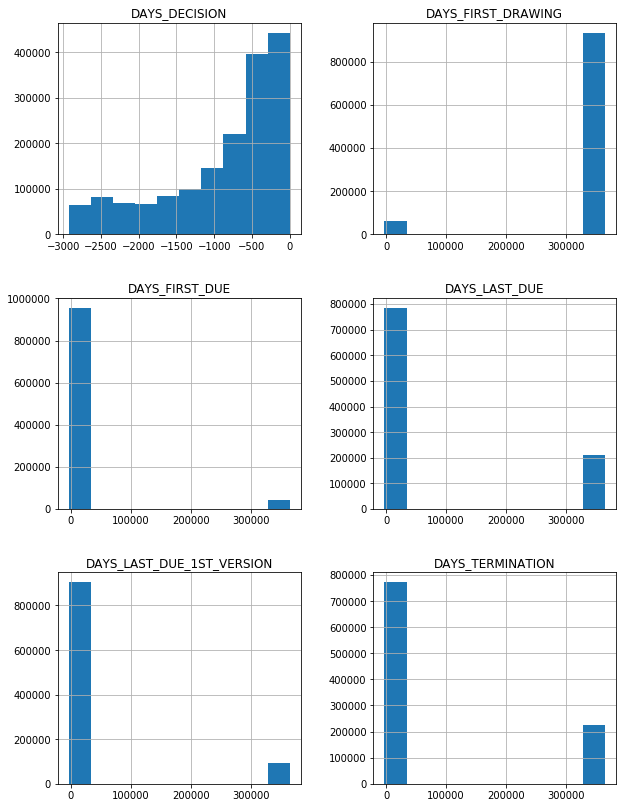

In [29]:
previous[col_days_previous].hist(figsize=(10,14))

In [31]:
for col in col_days_previous:
    print(col,previous[previous[col]>300000][col].unique())

DAYS_DECISION []
DAYS_FIRST_DRAWING [365243.]
DAYS_FIRST_DUE [365243.]
DAYS_LAST_DUE_1ST_VERSION [365243.]
DAYS_LAST_DUE [365243.]
DAYS_TERMINATION [365243.]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1dfa937048>,
      dtype=object)

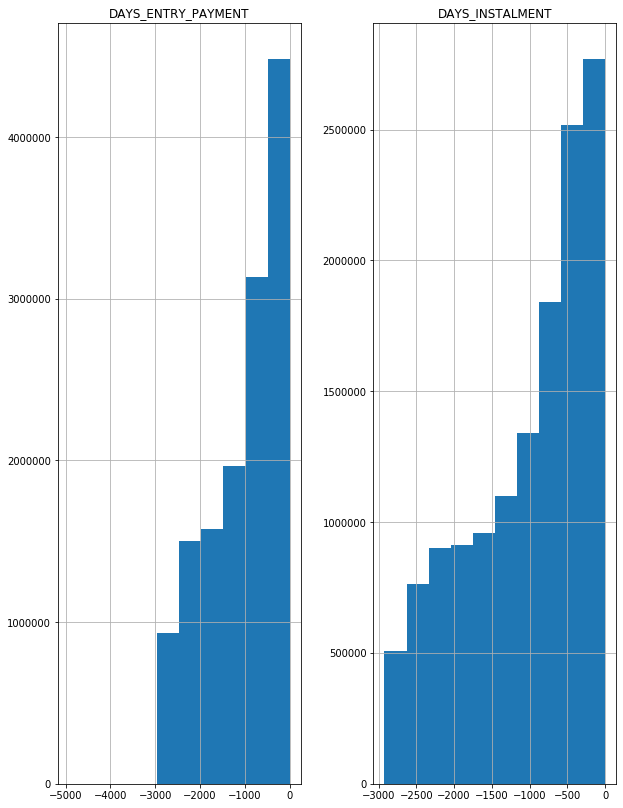

In [30]:
installments[col_days_installments].hist(figsize=(10,14))

### Data anomoly handling
From the analysis above. We know that the data anomoly happens in the number of days field : 365243 days (365243 / 365.25 = 999 yrs). This anomoly might comes from the mistype Therefore, we should repace 365243 with np.nan in every dataframe.

In [36]:
# before transformming 365243 to np.nan, make sure carefully that we consider all the columns. 
for col in app:
    is_true = app.isin([365243])[col].any()
    if (is_true):
        print("app",col)
for col in bureau:
    is_true = bureau.isin([365243])[col].any()
    if (is_true):
        print("bureau",col)
for col in bureau_balance:
    is_true = bureau_balance.isin([365243])[col].any()
    if (is_true):
        print("bureau_balance",col)
for col in cash:
    is_true = cash.isin([365243])[col].any()
    if (is_true):
        print("cash",col)
for col in credit:
    is_true = credit.isin([365243])[col].any()
    if (is_true):
        print("credit",col)
for col in previous:
    is_true = previous.isin([365243])[col].any()
    if (is_true):
        print("previous",col)
for col in installments:
    is_true = installments.isin([365243])[col].any()
    if (is_true):
        print("installments",col)

app DAYS_EMPLOYED
app SK_ID_CURR
bureau SK_ID_CURR
cash SK_ID_CURR
previous SK_ID_CURR
previous DAYS_FIRST_DRAWING
previous DAYS_FIRST_DUE
previous DAYS_LAST_DUE_1ST_VERSION
previous DAYS_LAST_DUE
previous DAYS_TERMINATION
installments SK_ID_CURR


In [37]:
# We should repace 365243 with np.nan all the columns mentioned above except "SK_ID_CURR" 
app[col_days_app] = app[col_days_app].replace({365243: np.nan})
previous[col_days_previous] = previous[col_days_previous].replace({365243: np.nan})

Memory Reduction
--
Converting the data type to some smaller subtype such as float64 to float32 can reduce the memory usage. This step is important when the datasets is large. Without this step, the feature matrix calculation might fail due to the lack of memory in the disk. In addition, we should also need to make sure that the keys, which are used to define the relationships, must have the same data type.

In [38]:
print('type of bureau[SK_ID_BUREAU]',bureau['SK_ID_BUREAU'].dtypes)
print('type of bureau_balance[SK_ID_BUREAU]',bureau_balance['SK_ID_BUREAU'].dtypes)
print('type of app[SK_ID_CURR]',app['SK_ID_CURR'].dtypes)
print('type of bureau[SK_ID_CURR]',bureau['SK_ID_CURR'].dtypes)
print('type of previous[SK_ID_CURR]',previous['SK_ID_CURR'].dtypes)
print('type of previous[SK_ID_PREV]',previous['SK_ID_PREV'].dtypes)
print('type of cash[SK_ID_PREV]',cash['SK_ID_PREV'].dtypes)
print('type of installments[SK_ID_PREV]',installments['SK_ID_PREV'].dtypes)
print('type of credit[SK_ID_PREV]',credit['SK_ID_PREV'].dtypes)

type of bureau[SK_ID_BUREAU] int64
type of bureau_balance[SK_ID_BUREAU] int64
type of app[SK_ID_CURR] int64
type of bureau[SK_ID_CURR] int64
type of previous[SK_ID_CURR] int64
type of previous[SK_ID_PREV] int64
type of cash[SK_ID_PREV] int64
type of installments[SK_ID_PREV] int64
type of credit[SK_ID_PREV] int64


In [7]:
#bureau = bureau.astype({'SK_ID_BUREAU': 'int32','SK_ID_CURR':'float32'})
#bureau_balance = bureau_balance.astype({'SK_ID_BUREAU': 'float32'})
#app = app.astype({'SK_ID_CURR': 'float32'})
#previous = previous.astype({'SK_ID_CURR': 'float32','SK_ID_PREV': 'float32'})
#cash = cash.astype({'SK_ID_PREV': 'float32'})
#installments = installments.astype({'SK_ID_PREV': 'float32'})
#credit = credit.astype({'SK_ID_PREV': 'float32'})

In [39]:
def convert_types(df):
    """Convert data types in a pandas dataframe. Purpose is to reduce size of dataframe."""
    for col in df:
        if ('SK_ID' in col):
            df[col] = df[col].fillna(0).astype(np.int32)
        elif (df[col].dtype == 'object') and (df[col].nunique() < df.shape[0]):
            df[col] = df[col].astype('category')
        elif list(df[col].unique()) == [1, 0]:
            df[col] = df[col].astype(bool)
        elif df[col].dtype == float:
            df[col] = df[col].astype(np.float32)
        elif df[col].dtype == int:
            df[col] = df[col].astype(np.int32)
    return df

In [40]:
app = convert_types(app)
bureau = convert_types(bureau)
bureau_balance = convert_types(bureau_balance)
cash = convert_types(cash)
credit = convert_types(credit)
previous = convert_types(previous)
installments = convert_types(installments)

Feature Engineering: filling the missing value
--
Some missing value are not really missing value. For example, if there is no parking lot in the house, the missing value of the variables like "parking_lot_area" might be 0 rather than the real missing value. The way to judge it is to see 1. whether all the missing values of the parking lot related variable occur in the same row. 2. whether there is a categorical variable like "parking lot type" having the category means "having no parking lot". This stage relies on the understanding of the domain knowledge.

In [21]:
def get_missing_values( df ):
    missing_values = pd.DataFrame(columns = ["number","percentage"])
    for col in df:
        if df[col].isnull().sum()>0:
            missing_values.loc[col] = [ df[col].isnull().sum() , df[col].isnull().sum()/df.shape[0] ]
    missing_values = missing_values.sort_values( 'percentage', ascending=False)
    return missing_values

In [22]:
missing_values = get_missing_values( app )

In [29]:
missing_values.tail(20)

,number,percentage
OCCUPATION_TYPE,111996.0,0.314370
EXT_SOURCE_3,69633.0,0.195458
DAYS_EMPLOYED,64648.0,0.181466
TARGET,48744.0,0.136823
AMT_REQ_CREDIT_BUREAU_MON,47568.0,0.133522
AMT_REQ_CREDIT_BUREAU_QRT,47568.0,0.133522
AMT_REQ_CREDIT_BUREAU_WEEK,47568.0,0.133522
AMT_REQ_CREDIT_BUREAU_YEAR,47568.0,0.133522
AMT_REQ_CREDIT_BUREAU_DAY,47568.0,0.133522
AMT_REQ_CREDIT_BUREAU_HOUR,47568.0,0.133522


In [28]:
app[['YEARS_BUILD_AVG','YEARS_BUILD_MODE','YEARS_BUILD_MEDI']]

,YEARS_BUILD_AVG,YEARS_BUILD_MODE,YEARS_BUILD_MEDI
0,0.6192,0.6341,0.6243
1,0.7960,0.8040,0.7987
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


## Feature Engineering: date/time variables

date/time variables have periodicity. In order to keep this kind of property into consideration, we must take the cos and sin components of these variable

In [41]:
# Get the possible variables which represent date/time
def get_col_datetime( df ):
    patterns = [re.compile(r'week',re.IGNORECASE), re.compile(r'hour',re.IGNORECASE), re.compile(r'month',re.IGNORECASE), 
                re.compile(r'date',re.IGNORECASE), re.compile(r'time',re.IGNORECASE)]
    col_datetime = []
    for col in df:
        for pattern in patterns:
            if( pattern.search(col) != None):
                col_datetime.append( col )
                break
    return col_datetime

In [42]:
col_datetime_app = get_col_datetime( app )
col_datetime_bureau = get_col_datetime( bureau )
col_datetime_bureau_balance = get_col_datetime( bureau_balance )
col_datetime_cash = get_col_datetime( cash )
col_datetime_credit = get_col_datetime( credit )
col_datetime_previous = get_col_datetime( previous )
col_datetime_installments = get_col_datetime( installments )

In [43]:
print(col_datetime_app)
print(col_datetime_bureau)
print(col_datetime_bureau_balance)
print(col_datetime_cash)
print(col_datetime_credit)
print(col_datetime_previous)
print(col_datetime_installments)

['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START']
['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']
['MONTHS_BALANCE']
['MONTHS_BALANCE']
['MONTHS_BALANCE']
['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']
[]


In [44]:
### Check each feature variables obtained from get_col_datetime
app[col_datetime_app].head(5)
#bureau[col_datetime_bureau]
#bureau_balance[col_datetime_bureau_balance]
#cash[col_datetime_cash]
#credit[col_datetime_credit]
#previous[col_datetime_previous]
#installments[col_datetime_installments]

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START
0,0.0,0.0,10,WEDNESDAY
1,0.0,0.0,11,MONDAY
2,0.0,0.0,9,MONDAY
3,NaN,NaN,17,WEDNESDAY
4,0.0,0.0,11,THURSDAY


Observation: only 'HOUR_APPR_PROCESS_START' and 'WEEKDAY_APPR_PROCESS_START' in app as well as in previous have the meaning datetime. Other features represent time difference. To keep the periodicity of hour time and weekday, we must translate them into the new features via periodic functions. Before we do this, we take some observation of the ratio of each TARGET with respect to the given 'HOUR_APPR_PROCESS_START'/'WEEKDAY_APPR_PROCESS_START'

### Check the distribution of these datetime-related feature in terms of loan is repayed or not
We check the both the distribution of the ratio of target value 0. In order to make sure whether there is significant difference between different values of the feature, we need to estimate the standard deviation of the sample ratio
$\sigma=\sqrt{\frac{p(1-p)}{N}}$ in order to get the confidence interval (95% confidence level means the interval $[p-2\sigma,p+2\sigma]$).

In [45]:
df1 = app.groupby('HOUR_APPR_PROCESS_START')['TARGET'].agg( ['value_counts'] )
df1['percentage'] = df1['value_counts'].div(df1.value_counts.sum(level=0),level=0)
df1['standard_deviation'] = np.sqrt(df1['percentage'].div(df1.value_counts.sum(level=0),level=0) * (1-df1['percentage']) )
df2=df1[df1.index.get_level_values('TARGET') ==1].droplevel('TARGET')[ ['value_counts','percentage','standard_deviation']]
print(df2)

                         value_counts  percentage  standard_deviation
HOUR_APPR_PROCESS_START                                              
0                                   6    0.150000            0.056458
1                                   7    0.081395            0.029486
2                                  30    0.098361            0.017052
3                                 107    0.086992            0.008036
4                                 173    0.082775            0.006027
5                                 385    0.105827            0.005100
6                                 645    0.110407            0.004100
7                                 917    0.100427            0.003145
8                                1373    0.090765            0.002336
9                                2247    0.082055            0.001658
10                               3026    0.080218            0.001399
11                               3006    0.080744            0.001412
12                  

<ErrorbarContainer object of 3 artists>

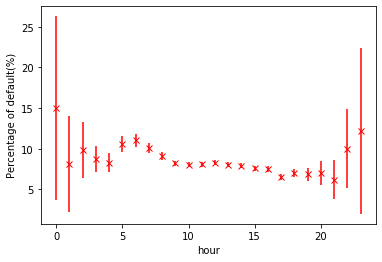

In [46]:
plt.xlabel('hour')
plt.ylabel('Percentage of default(%)')
plt.errorbar(df2.index, df2['percentage']*100, yerr=df2['standard_deviation']*2*100,color='red', marker='x',ls = '')

In [47]:
df1 = app.groupby('WEEKDAY_APPR_PROCESS_START')['TARGET'].agg( ['value_counts'] )
df1['percentage'] = df1['value_counts'].div(df1.value_counts.sum(level=0),level=0)
df1['standard_deviation'] = np.sqrt(df1['percentage'].div(df1.value_counts.sum(level=0),level=0) * (1-df1['percentage']) )
df2=df1[df1.index.get_level_values('TARGET') ==1].droplevel('TARGET')[ ['value_counts','percentage','standard_deviation']]
df2 = df2.reindex(['SUNDAY', 'MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY'])
print(df2)

                            value_counts  percentage  standard_deviation
WEEKDAY_APPR_PROCESS_START                                              
SUNDAY                              1283    0.079291            0.002124
MONDAY                              3934    0.077572            0.001188
TUESDAY                             4501    0.083505            0.001192
WEDNESDAY                           4238    0.081604            0.001201
THURSDAY                            4098    0.081003            0.001213
FRIDAY                              4101    0.081469            0.001219
SATURDAY                            2670    0.078873            0.001465


<ErrorbarContainer object of 3 artists>

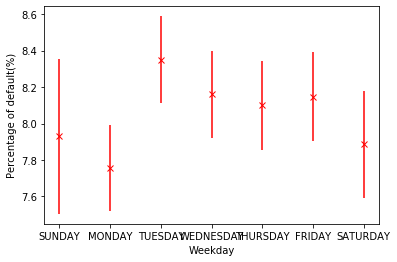

In [48]:
plt.xlabel('Weekday')
plt.ylabel('Percentage of default(%)')
plt.errorbar(df2.index, df2['percentage']*100, yerr=df2['standard_deviation']*2*100,color='red', marker='x',ls = '')

### Observation
The percentage of default shows statistically significant difference between different "HOUR_APPR_PROCESS_START". It only shows statistically significant difference between between Monday and Tuesday for 'WEEKDAY_APPR_PROCESS_START' with a 95% level of confidence. 'TUESDAY' to 'FRIDAY' and 'SATURDAY' to 'MONDAY' show difference with a 67% level of confidence.

In [49]:
def weekday_map(x):
    WEEKDAY_MAP = {'SUNDAY':0,'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':6}
    return WEEKDAY_MAP[x]

In [66]:
app['WEEKDAY_APPR_PROCESS_START_COS'] = np.cos( app['WEEKDAY_APPR_PROCESS_START'].apply(weekday_map).astype(np.int32) * 2*np.pi/7 ).astype(np.float32)
app['WEEKDAY_APPR_PROCESS_START_SIN'] = np.sin( app['WEEKDAY_APPR_PROCESS_START'].apply(weekday_map).astype(np.int32) * 2*np.pi/7 ).astype(np.float32)
app['HOUR_APPR_PROCESS_START_COS'] = np.cos( app['HOUR_APPR_PROCESS_START'] * 2*np.pi/24 ).astype(np.float32)
app['HOUR_APPR_PROCESS_START_SIN'] = np.sin( app['HOUR_APPR_PROCESS_START'] * 2*np.pi/24 ).astype(np.float32)
previous['WEEKDAY_APPR_PROCESS_START_COS'] = np.cos( previous['WEEKDAY_APPR_PROCESS_START'].apply(weekday_map).astype(np.int32) * 2*np.pi/7 ).astype(np.float32)
previous['WEEKDAY_APPR_PROCESS_START_SIN'] = np.sin( previous['WEEKDAY_APPR_PROCESS_START'].apply(weekday_map).astype(np.int32) * 2*np.pi/7 ).astype(np.float32)
previous['HOUR_APPR_PROCESS_START_COS'] = np.cos( previous['HOUR_APPR_PROCESS_START'] * 2*np.pi/24 ).astype(np.float32)
previous['HOUR_APPR_PROCESS_START_SIN'] = np.sin( previous['HOUR_APPR_PROCESS_START'] * 2*np.pi/24 ).astype(np.float32)

In [70]:
app = app.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1)
previous = previous.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1)

## Feature Engineering with the categorical variables which might have intrinsic order
Some categorical variables which might have intrinsic order should be carefully checked. They might be better interpreted as numerical features. For example, the education-related feature "NAME_EDUCATION_TYPE" is a candidate we should check.

In [71]:
df1 = app.groupby('NAME_EDUCATION_TYPE')['TARGET'].agg( ['value_counts'] )
df1['percentage'] = df1['value_counts'].div(df1.value_counts.sum(level=0),level=0)
df1['standard_deviation'] = np.sqrt(df1['percentage'].div(df1.value_counts.sum(level=0),level=0) * (1-df1['percentage']) )
df2=df1[df1.index.get_level_values('TARGET') ==0].droplevel('TARGET')[ ['value_counts','percentage','standard_deviation']]
print(df2)

                               value_counts  percentage  standard_deviation
NAME_EDUCATION_TYPE                                                        
Academic degree                         161    0.981707            0.010464
Higher education                      70854    0.946449            0.000823
Incomplete higher                      9405    0.915150            0.002749
Lower secondary                        3399    0.890723            0.005050
Secondary / secondary special        198867    0.910601            0.000611


<ErrorbarContainer object of 3 artists>

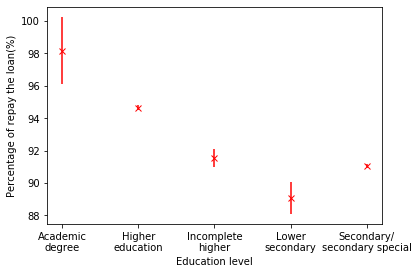

In [72]:
plt.xlabel('Education level')
plt.ylabel('Percentage of repay the loan(%)')
x_label = ['Academic\ndegree','Higher\neducation','Incomplete\nhigher','Lower\nsecondary', 'Secondary/\nsecondary special' ]
plt.errorbar(x_label, df2['percentage']*100, yerr=df2['standard_deviation']*2*100,color='red', marker='x',ls = '')

Observation: The categorical variable 'NAME_EDUCATION_TYPE' has statistically significant difference for each categories. We can provide them the order 'Academic degree':0, 'Higher education':1, 'Incomplete higher'/ 'Secondary / secondary special':2, 'Lower secondary':3. Only 'Incomplete higher' and 'Secondary / secondary special' don't show statistically significant difference. We can create a new categorical feature with name like 'EDUCATION_TYPE': {'Incomplete higher', 'Secondary / secondary special', 'others'}.

In [74]:
education_dic1 = { 'Academic degree': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Secondary / secondary special': 2, 'Lower secondary': 3 }
education_dic2 = { 'Academic degree': 'others', 'Higher education': 'others', 'Lower secondary': 'others' }
app['EDUCATION_VALUE'] = app['NAME_EDUCATION_TYPE'].replace(education_dic1).astype(np.int32)
app['NAME_EDUCATION_TYPE'] = app['NAME_EDUCATION_TYPE'].replace(education_dic2)

Feature Engineering with domain knowledge
--
when reading the HomeCredit_columns_descriptions.csv carefully, we can find that some features like DAYS_EMPLOYED (total days of being employed), AMT_INCOME_TOTAL (total income of the applicant per annum), AMT_ANNUITY (the annuity of each credit loan) can be used to create some interesting features like: INCOME_PER_DAYS_EMPLOYED = AMT_INCOME_TOTAL/DAYS_EMPLOYED.

In [87]:
app['INCOME_PER_DAYS_EMPLOYED'] = app['AMT_INCOME_TOTAL']/app['DAYS_EMPLOYED']
app['LOG_INCOME'] = np.log10( app['AMT_INCOME_TOTAL'] + 1 )
app['AMT_PER_INCOME'] = app['AMT_ANNUITY']/app['AMT_INCOME_TOTAL']
app['CREDIT_PER_ANNUITY'] = app['AMT_CREDIT']/app['AMT_ANNUITY']
app['CREDIT_PER_INCOME'] = app['AMT_CREDIT']/app['AMT_INCOME_TOTAL']
previous['CREDIT_PER_ANNUITY'] = previous['AMT_CREDIT']/previous['AMT_ANNUITY']

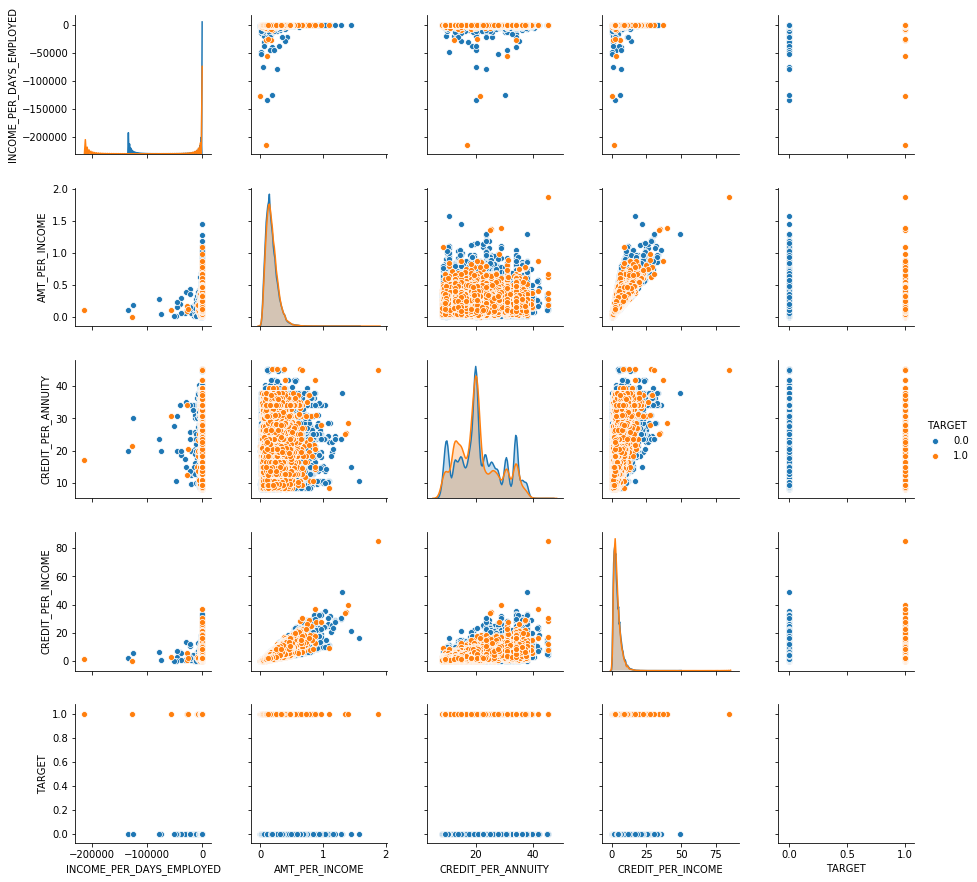

In [84]:
sns.pairplot( app[[ 'INCOME_PER_DAYS_EMPLOYED', 'AMT_PER_INCOME', 'CREDIT_PER_ANNUITY','CREDIT_PER_INCOME', 'TARGET' ]], hue='TARGET' )

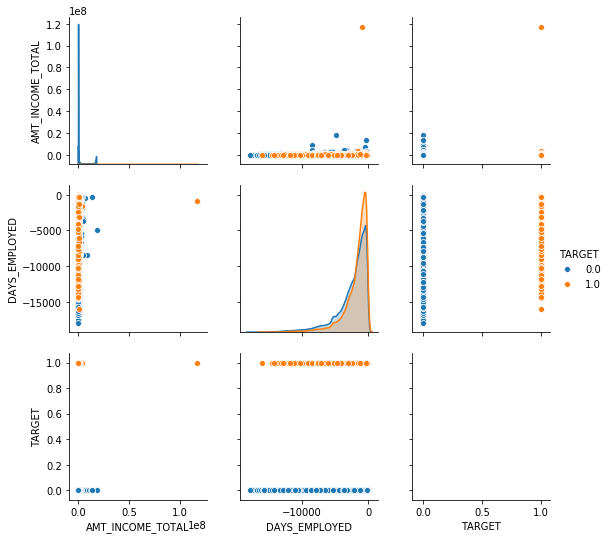

In [85]:
sns.pairplot( app[[ 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'TARGET' ]][app['AMT_INCOME_TOTAL']<0.5*10**8], hue='TARGET' )

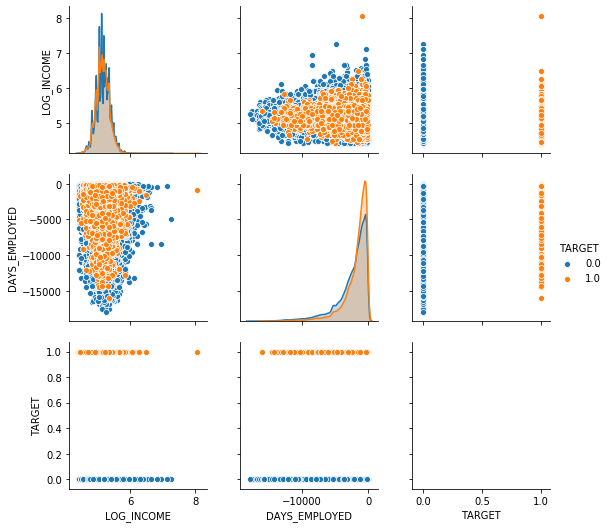

In [88]:
sns.pairplot( app[[ 'LOG_INCOME', 'DAYS_EMPLOYED', 'TARGET' ]], hue='TARGET' )

## Feature Engineering with missing value for the categorical variables

In [89]:
def fill_missing_categorical(df):
    for col in df:
        if (df[col].dtype.name == 'object' or df[col].dtype.name == 'category'):
            n_missing = df[col].isnull().sum()
            if( n_missing > 0 ):
                print(col, ",# of category:" ,feature_matrix[col].unique(), ",# of missing value:", n_missing)
                if( df[col].dtype.name == 'category' ):
                    df[col] = df[col].cat.add_categories(['NA'])
                df[col].fillna('NA', inplace=True)

In [90]:
app = convert_types(app)
bureau = convert_types(bureau)
bureau_balance = convert_types(bureau_balance)
cash = convert_types(cash)
credit = convert_types(credit)
previous = convert_types(previous)
installments = convert_types(installments)

Feature Engineering with the usage of featuretools
--

In [91]:
    # Empty entityset
    es = ft.EntitySet(id = 'clients')
    
    # Entities with a unique index
    es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

    es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

    es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

    # Entities that do not have a unique index
    es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                                  make_index = True, index = 'bureaubalance_index')

    es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                                  make_index = True, index = 'cash_index')

    es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                                  make_index = True, index = 'installments_index')

    es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                                  make_index = True, index = 'credit_index')

In [92]:
    r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

    # Relationship between bureau and bureau balance
    r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

    # Relationship between current app and previous apps
    r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

    # Relationships between previous apps and cash, installments, and credit
    r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
    r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
    r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])
    
    # Add in the defined relationships
    es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                               r_previous_cash, r_previous_installments, r_previous_credit])

In [93]:
agg_primitives =  ["sum", "max", "min", "mean", "count", "percent_true", "num_unique", "mode"]
# Deep feature synthesis 
feature_names = ft.dfs(entityset=es, target_entity='app',
                       agg_primitives = agg_primitives,
                       n_jobs = 1, verbose = 1,
                       features_only = True,
                       max_depth = 2)

Built 1358 features


In [94]:
import datetime

In [95]:
now1 = datetime.datetime.now()
print("start time",now1)
feature_matrix = ft.calculate_feature_matrix(feature_names, 
                                             entityset=es, 
                                             n_jobs = 1, 
                                             verbose = 0,
                                             chunk_size = 0.2 )

now2 = datetime.datetime.now()
print("end time",now2)

start time 2020-06-09 05:11:22.345763
end time 2020-06-09 14:25:51.697126


In [96]:
import os
feature_matrix.reset_index(inplace = True)

if not os.path.exists('feature_matrix'):
    os.makedirs('feature_matrix')

feature_matrix.to_csv('feature_matrix/feature_matrix.csv', index = False)

In [67]:
# Read the saved feature matrix.
#feature_matrix=pd.read_csv('feature_matrix/feature_matrix.csv')
#feature_matrix = convert_types(feature_matrix)

In [97]:
print('Shape: ', feature_matrix.shape)

Shape:  (356255, 1359)


Feature selection
--

**Remove any columns built on the SK_ID**

In [98]:
cols_with_curr_id = [col for col in feature_matrix.columns if 'SK_ID_CURR' in col]
cols_with_bureau_id = [col for col in feature_matrix.columns if 'SK_ID_BUREAU' in col]
cols_with_previous_id = [col for col in feature_matrix.columns if 'SK_ID_PREV' in col]
print('There are {} columns that contain SK_ID_CURR'.format( len(cols_with_curr_id)) )
print('There are {} columns that contain SK_ID_BUREAU'.format( len(cols_with_bureau_id)) )
print('There are {} columns that contain SK_ID_PREV'.format( len(cols_with_previous_id)) )

There are 60 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV


In [99]:
feature_matrix = feature_matrix.drop(columns = cols_with_curr_id)
print('Shape: ', feature_matrix.shape)

Shape:  (356255, 1299)


**Remove Missing Values**

We must set up the minimum threshold of percentage of missing values for removing. Here we set up this threshold 60%. That means if any columns have greater than 60% missing values, they will be removed.

In [106]:
# Missing values in percent
feature_missing = (feature_matrix.isnull().sum() / len(feature_matrix)).sort_values(ascending = False)
feature_missing.head()

MIN(credit.previous.DAYS_LAST_DUE_1ST_VERSION)    1.0
MAX(credit.previous.RATE_INTEREST_PRIVILEGED)     1.0
MAX(credit.previous.RATE_INTEREST_PRIMARY)        1.0
MIN(credit.previous.RATE_INTEREST_PRIMARY)        1.0
MEAN(credit.previous.RATE_INTEREST_PRIVILEGED)    1.0
dtype: float64

In [107]:
# Identify missing values above threshold
missing_threshold = 0.6
feature_missing_0 = feature_missing.index[feature_missing > 0.5/feature_matrix.shape[0] ]
feature_missing = feature_missing.index[feature_missing > missing_threshold]

print('There are {} columns with missing values'.format( len(feature_missing_0) ) )
print('There are {} columns with more than {}% missing values'.format( len(feature_missing), missing_threshold*100) )

There are 989 columns with missing values
There are 407 columns with more than 60.0% missing values


In [108]:
feature_matrix = feature_matrix.drop(columns = feature_missing)
print('Shape: ', feature_matrix.shape)

Shape:  (356255, 892)


**Remove Collinear Variables**

Collinear features lead to decreased generalization performance on the test set. In order to solve this problem, only one of the collinear feature is preserved and others are removed. In order to achieve this purpose, the correlation matrix must be calculated first. Then we traverse across the strickly upper triangular part of correlation matrix to remove a highly correlated variable (Here threshold = 0.9) in the column of the matrix.

In [109]:
# Absolute value correlation matrix
corr_matrix = feature_matrix.corr().abs()
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,SUM(credit.previous.DAYS_FIRST_DUE),SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.WEEKDAY_APPR_PROCESS_START_COS),SUM(credit.previous.HOUR_APPR_PROCESS_START_SIN),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.CNT_PAYMENT),SUM(credit.previous.AMT_CREDIT),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),PERCENT_TRUE(credit.previous.NFLAG_LAST_APPL_IN_DAY)
AMT_ANNUITY,NaN,0.762521,0.768123,0.204391,0.001472,0.003162,0.029877,0.017053,0.009583,0.015458,...,0.013035,0.020788,0.007876,0.001154,0.021532,0.003224,NaN,0.030761,NaN,0.005610
AMT_CREDIT,NaN,NaN,0.987159,0.166590,0.005411,0.002333,0.058050,0.004341,0.002961,0.047656,...,0.040907,0.041174,0.010495,0.002453,0.018613,0.008461,NaN,0.044191,NaN,0.005019
AMT_GOODS_PRICE,NaN,NaN,NaN,0.169445,0.005816,0.001688,0.059851,0.004691,0.003229,0.050080,...,0.036560,0.039672,0.010691,0.001603,0.018978,0.007913,NaN,0.037172,NaN,0.005478
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.002743,0.000767,0.022736,0.006712,0.001447,0.011153,...,0.006726,0.006089,0.005027,0.001161,0.015014,0.000648,NaN,0.033342,NaN,0.014562
AMT_REQ_CREDIT_BUREAU_DAY,NaN,NaN,NaN,NaN,NaN,0.227493,0.003313,0.005853,0.214474,0.003224,...,0.002240,0.004050,0.002707,0.004074,0.000334,0.001722,NaN,0.002717,NaN,0.003246


In [110]:
corr_matrix.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,SUM(credit.previous.DAYS_FIRST_DUE),SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.WEEKDAY_APPR_PROCESS_START_COS),SUM(credit.previous.HOUR_APPR_PROCESS_START_SIN),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.CNT_PAYMENT),SUM(credit.previous.AMT_CREDIT),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),PERCENT_TRUE(credit.previous.NFLAG_LAST_APPL_IN_DAY)
AMT_ANNUITY,1.000000,0.762521,0.768123,0.204391,0.001472,0.003162,0.029877,0.017053,0.009583,0.015458,...,0.013035,0.020788,0.007876,0.001154,0.021532,0.003224,NaN,0.030761,NaN,0.005610
AMT_CREDIT,0.762521,1.000000,0.987159,0.166590,0.005411,0.002333,0.058050,0.004341,0.002961,0.047656,...,0.040907,0.041174,0.010495,0.002453,0.018613,0.008461,NaN,0.044191,NaN,0.005019
AMT_GOODS_PRICE,0.768123,0.987159,1.000000,0.169445,0.005816,0.001688,0.059851,0.004691,0.003229,0.050080,...,0.036560,0.039672,0.010691,0.001603,0.018978,0.007913,NaN,0.037172,NaN,0.005478
AMT_INCOME_TOTAL,0.204391,0.166590,0.169445,1.000000,0.002743,0.000767,0.022736,0.006712,0.001447,0.011153,...,0.006726,0.006089,0.005027,0.001161,0.015014,0.000648,NaN,0.033342,NaN,0.014562
AMT_REQ_CREDIT_BUREAU_DAY,0.001472,0.005411,0.005816,0.002743,1.000000,0.227493,0.003313,0.005853,0.214474,0.003224,...,0.002240,0.004050,0.002707,0.004074,0.000334,0.001722,NaN,0.002717,NaN,0.003246


In [111]:
# Identigy the threshold for removing correlated variables
corr_threshold = 0.9
# Select columns with correlations above threshold
feature_collinear = [col for col in upper.columns if any(upper[col] > corr_threshold)]

print('There are {} columns to remove.'.format( len(feature_collinear) ) )

There are 393 columns to remove.


In [112]:
feature_matrix = feature_matrix.drop(columns = feature_collinear)
print('Shape: ', feature_matrix.shape)

Shape:  (356255, 499)


Encode the categorical variables
--
Label encoder for categorical variables with 2 unique categories (or 1 categories + np.nan) and One-hot Encoder for categorical variables with more than 2 unique categories.

In [117]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in feature_matrix.columns:
    if (feature_matrix[col].dtype.name == 'object' or feature_matrix[col].dtype.name == 'category'):
        # If 2 or fewer unique categories
        if len(list(feature_matrix[col].unique())) <= 2:
            print(col ,feature_matrix[col].unique(),feature_matrix[col].dtype.name)
            if( feature_matrix[col].dtype.name == 'category' and feature_matrix[col].isnull().sum() > 0 ):
                feature_matrix[col] = feature_matrix[col].cat.add_categories(['NA'])
                feature_matrix[col].fillna('NA', inplace=True)
            if (feature_matrix[col].dtype.name == 'object'):
                feature_matrix[col].fillna('NA', inplace=True)
            le.fit(feature_matrix[col])
            feature_matrix[col] = le.transform(feature_matrix[col])
            # number of columns were label encoded
            le_count += 1
print('{} columns were label encoded.'.format(le_count) )

MODE(cash.previous.NAME_CONTRACT_STATUS) ['Approved' nan] object
MODE(cash.previous.FLAG_LAST_APPL_PER_CONTRACT) ['Y' nan] object
MODE(cash.previous.CODE_REJECT_REASON) ['XAP' nan] object
MODE(installments.previous.NAME_CONTRACT_STATUS) ['Approved' nan] object
MODE(installments.previous.FLAG_LAST_APPL_PER_CONTRACT) ['Y' nan] object
5 columns were label encoded.


In [118]:
# Get one-hot encoder
feature_matrix = pd.get_dummies( feature_matrix, dummy_na=True )
print('shape', feature_matrix.shape )

shape (356255, 1016)


## Additional feature engineering (KNN)
We use K-Nearest Neighbors (KNN) to add a "local knowledge" feature. To achieve this purpose, we can choose some features which present different distribution between different class label and then estimate the predicted class probability. Then then this predicted class probability is used as a new feature for downstream modeling. 

More discussion about KNN as feature engineering: P.386 from Bruce, Peter, and Andrew Bruce. 2017. Practical Statistics for Data Scientists: 50 Essential Concepts. O’Reilly Media, Inc.

In [223]:
# The feature I forget to add before the automatic feature engineering...
feature_matrix['DAYS_EMPLOYED_PER_BIRTH'] = feature_matrix['DAYS_EMPLOYED']/ feature_matrix['DAYS_BIRTH']
feature_matrix['CREDIT_PER_GOODS'] = app['AMT_CREDIT']/app['AMT_GOODS_PRICE']

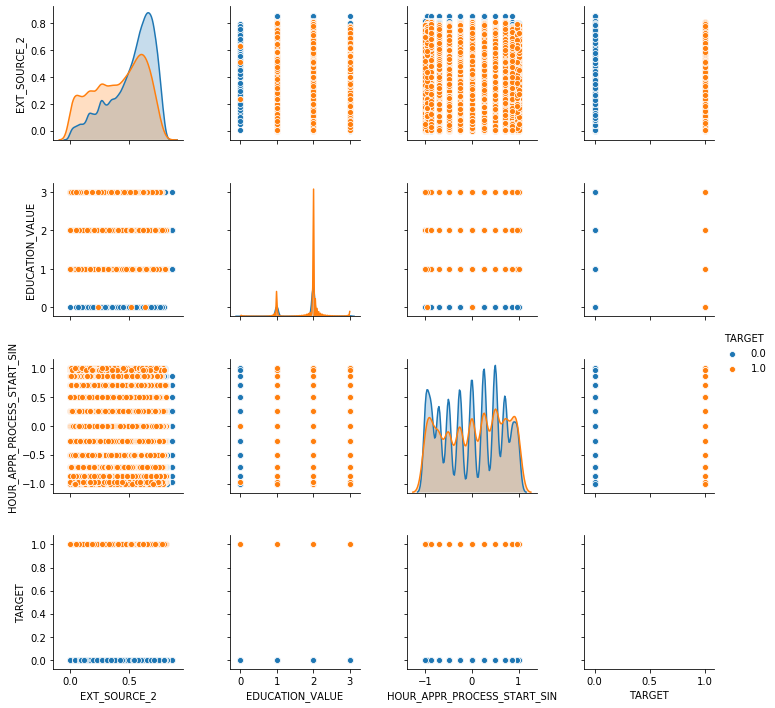

In [249]:
#sns.pairplot(feature_matrix[["AMT_CREDIT","CREDIT_PER_GOODS","TARGET"]],hue="TARGET")
sns.pairplot(feature_matrix[["EXT_SOURCE_2","EDUCATION_VALUE","HOUR_APPR_PROCESS_START_SIN","TARGET"]],hue="TARGET")

In [286]:
for item in ["EXT_SOURCE_2","EXT_SOURCE_3", "EDUCATION_VALUE","HOUR_APPR_PROCESS_START_SIN","DAYS_EMPLOYED_PER_BIRTH"]:
#for item in ["EXT_SOURCE_2","EXT_SOURCE_3",'DAYS_EMPLOYED_PER_BIRTH', "AMT_CREDIT", "AMT_GOODS_PRICE"]:
    print( item, feature_matrix[item].isnull().sum()/len(feature_matrix[item]))

EXT_SOURCE_2 0.0018750614026469803
EXT_SOURCE_3 0.19545830935706165
EDUCATION_VALUE 0.0
HOUR_APPR_PROCESS_START_SIN 0.0
DAYS_EMPLOYED_PER_BIRTH 0.18146552329090118


In [251]:
def df_normalization(df,feature):
    df[feature] = (df[feature] - df[feature].min())/(df[feature].max()-df[feature].min())

In [252]:
KNN_feature = ["EXT_SOURCE_2","EXT_SOURCE_3","DAYS_EMPLOYED_PER_BIRTH", "EDUCATION_VALUE","HOUR_APPR_PROCESS_START_SIN"]
KNN_feature_target = KNN_feature.copy()
KNN_feature_target.append('TARGET')
df1 = feature_matrix[KNN_feature].dropna()
df_normalization(df1,"EDUCATION_VALUE")
df_normalization(df1,"HOUR_APPR_PROCESS_START_SIN")
df_normalization(df1,"DAYS_EMPLOYED_PER_BIRTH")
#feature_matrix["EDUCATION_VALUE"] = (feature_matrix["EDUCATION_VALUE"] - feature_matrix["EDUCATION_VALUE"].min())/(feature_matrix["EDUCATION_VALUE"].max()-feature_matrix["EDUCATION_VALUE"].min())
#feature_matrix["HOUR_APPR_PROCESS_START_SIN"] = (feature_matrix["HOUR_APPR_PROCESS_START_SIN"] - feature_matrix["HOUR_APPR_PROCESS_START_SIN"].min())/(feature_matrix["HOUR_APPR_PROCESS_START_SIN"].max()-feature_matrix["HOUR_APPR_PROCESS_START_SIN"].min())
#for item in df1.columns:
#    print(df1[item].max())
neigh = KNeighborsClassifier(n_neighbors=500)
df2 = df1.copy()
df2 = pd.concat([df2, feature_matrix["TARGET"]], axis=1, sort=False)
df2 = df2[KNN_feature_target].dropna()
neigh.fit(df2[KNN_feature], df2["TARGET"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='uniform')

In [253]:
KNN_result = neigh.predict_proba(df1[KNN_feature])

In [258]:
df1["NEIGHBOR_PROB"] = KNN_result[:,0].tolist()
df2 = pd.concat([df2, df1["NEIGHBOR_PROB"]], axis=1, sort=False)
#df1['NEIGHBOR_PROB'] = KNN_result[:,0].tolist()

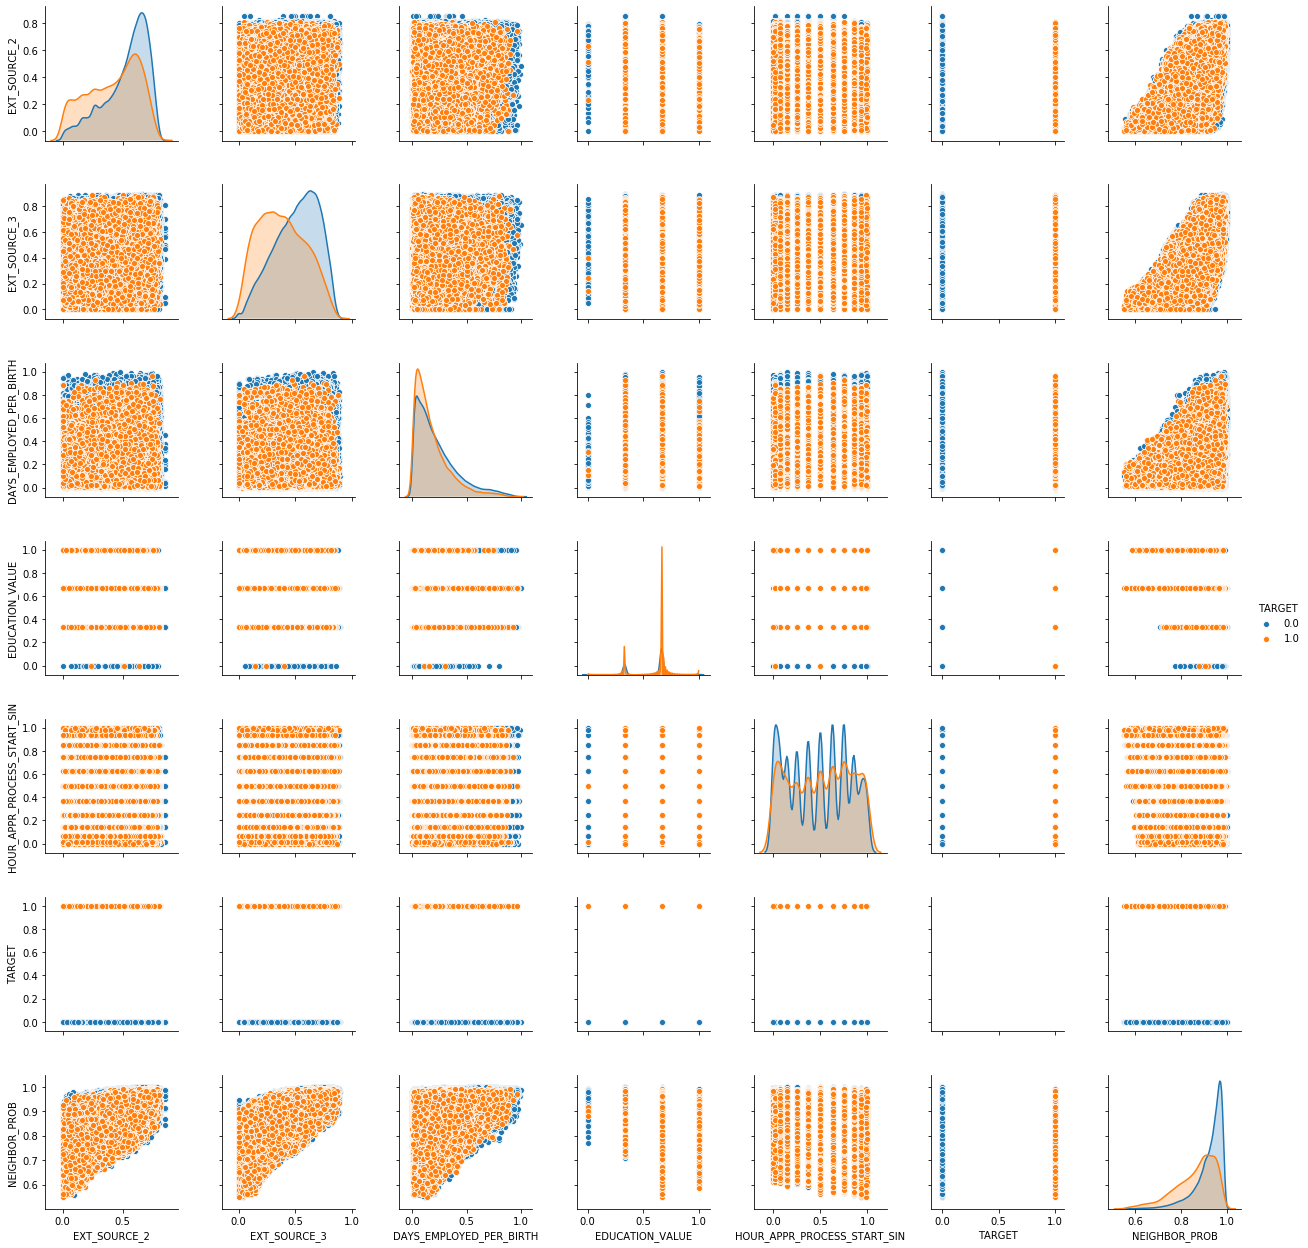

In [259]:
sns.pairplot(df2,hue="TARGET")

In [229]:
feature_matrix

,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,...,MODE(installments.previous.NAME_PRODUCT_TYPE)_XNA,MODE(installments.previous.NAME_PRODUCT_TYPE)_walk-in,MODE(installments.previous.NAME_PRODUCT_TYPE)_x-sell,MODE(installments.previous.NAME_PRODUCT_TYPE)_nan,MODE(installments.previous.NAME_CONTRACT_TYPE)_Cash loans,MODE(installments.previous.NAME_CONTRACT_TYPE)_Consumer loans,MODE(installments.previous.NAME_CONTRACT_TYPE)_Revolving loans,MODE(installments.previous.NAME_CONTRACT_TYPE)_nan,DAYS_EMPLOYED_PER_BIRTH,CREDIT_PER_GOODS
0,24700.5,406597.5,202500.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,...,1,0,0,0,0,1,0,0,0.067329,1.158397
1,35698.5,1293502.5,270000.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,...,1,0,0,0,0,1,0,0,0.070862,1.145199
2,6750.0,135000.0,67500.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,1,0,0,0,0,1,0,0,0.011814,1.000000
3,29686.5,312682.5,135000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,1,0,0,0.159905,1.052803
4,21865.5,513000.0,121500.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0,0,1,0,1,0,0,0,0.152418,1.000000
5,27517.5,490495.5,99000.00000,0.0,0.0,0.0,1.0,0.0,1.0,NaN,...,1,0,0,0,0,1,0,0,0.093737,1.079198
6,41301.0,1560726.0,171000.00000,0.0,0.0,1.0,1.0,0.0,2.0,NaN,...,1,0,0,0,0,1,0,0,0.227174,1.118800
7,42075.0,1530000.0,360000.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,1,0,0,0,0,1,0,0,0.023820,1.000000
8,33826.5,1019610.0,112500.00000,0.0,0.0,0.0,0.0,0.0,1.0,NaN,...,0,0,1,0,0,0,1,0,NaN,1.116158
9,20250.0,405000.0,135000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0.139540,1.000000


In [264]:
feature_matrix = pd.concat([feature_matrix, df1['NEIGHBOR_PROB']], axis=1, sort=False)

In [265]:
feature_matrix['NEIGHBOR_PROB']

0         0.722
1           NaN
2         0.944
3           NaN
4           NaN
5         0.914
6         0.988
7         0.980
8           NaN
9           NaN
10        0.938
11          NaN
12        0.870
13        0.956
14          NaN
15        0.914
16        0.656
17          NaN
18        0.980
19        0.964
20          NaN
21        0.856
22        0.922
23          NaN
24        0.966
25        0.950
26        0.836
27        0.938
28        0.952
29          NaN
          ...  
356225    0.974
356226    0.954
356227      NaN
356228      NaN
356229    0.954
356230    0.924
356231    0.940
356232    0.928
356233      NaN
356234    0.884
356235    0.834
356236    0.890
356237    0.934
356238    0.968
356239      NaN
356240      NaN
356241    0.912
356242      NaN
356243    0.882
356244    0.934
356245    0.924
356246      NaN
356247      NaN
356248    0.868
356249    0.914
356250    0.970
356251      NaN
356252    0.900
356253    0.966
356254    0.864
Name: NEIGHBOR_PROB, Len

Split the train and submission data
--

In [266]:
print(feature_matrix.TARGET.isnull()[feature_matrix.TARGET.isnull()==True].index)

Int64Index([307511, 307512, 307513, 307514, 307515, 307516, 307517, 307518,
            307519, 307520,
            ...
            356245, 356246, 356247, 356248, 356249, 356250, 356251, 356252,
            356253, 356254],
           dtype='int64', length=48744)


In [267]:
N_train = feature_matrix.TARGET.isnull()[feature_matrix.TARGET.isnull()==True].index[0]
print(N_train)

307511


In [268]:
train_data = feature_matrix[:N_train]
submission_data = feature_matrix[N_train:]

Split the train and test data
--

In [269]:
features_input = []
for col in train_data.columns:
    if col != 'TARGET':
        features_input.append( col )

In [270]:
X_train, X_test, y_train, y_test = train_test_split( train_data[features_input] , train_data['TARGET'] , test_size = 0.2  )

Train the XGBoost classification model with grid search
--
The package supporting missing value imputation should be used because there are still many missing values we don't want to handle manually. Here XGBoost is chosen, LightGBM is also an ideal choice. Here the tree model is chosen as the base model because the attribute feature_importance is favorable.

In [271]:
# next step: choose more max_depth
param_grid = {
#    'max_depth': [ 5,7,9,11],
    'max_depth': [ 5,7,9],
    'n_estimators': [100]
}

model = GridSearchCV( xgb.XGBClassifier() , param_grid = param_grid , scoring  = 'roc_auc', cv = 5, verbose=2, n_jobs=-1)

In [272]:
now1 = datetime.datetime.now()
print("start time",now1)
model.fit( X_train, y_train )
now2 = datetime.datetime.now()
print("end time",now2)

start time 2020-06-14 20:17:56.176451
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 522.2min finished


end time 2020-06-15 05:54:29.477963


In [287]:
#save the trained model
pkl_filename = "feature_matrix/xgb_cv.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Load from file. If there is trained model and we want to use it directly, uncomment these the following lines.
#pkl_filename = "feature_matrix/xgb_cv.pkl"
#with open(pkl_filename, 'rb') as file:
#    pickle_model = pickle.load(file)

In [273]:
print(model.best_estimator_)
print(model.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.7811132960883879


We compare the ROC AUC sore from the cross validation between different data preprocessing approaches.

|   | ROC AUC score  |   
|---|---|
| Only main table  | 0.74733  |  
| All the tables   | 0.77509  |  
| All the tables with manual FE  |  0.77865 |
| All the tables with manual FE and KNN  |  0.78110 |

In [274]:
feature_importance = model.best_estimator_.feature_importances_
feature_importance_sorted = sorted(feature_importance, reverse=True)
index_sorted = sorted(range(len(feature_importance)), key=lambda k: feature_importance[k], reverse=True )
feature_name = [col for col in feature_matrix.columns if col != "TARGET"]
feature_name_sorted = []
for index in index_sorted:
    feature_name_sorted.append( feature_name[index] )

feature_importance_table = pd.DataFrame( {'Feature': feature_name_sorted, 'Feature importance': feature_importance_sorted } )
#print(feature_importance_columns_sorted[0:15])
#print(feature_importance_sorted[0:15])

In [156]:
# ignore_index could be used only after pandas version 1.0.0, 
#feature_importance_table = pd.DataFrame( {'Feature': [col for col in feature_matrix.columns if col != "TARGET"] , 'Feature importance': model.best_estimator_.feature_importances_ } )
#feature_importance_table = feature_importance_table.sort_values(by='Feature importance', ascending=False, ignore_index=True )
#feature_importance_table.head(10)

TypeError: sort_values() got an unexpected keyword argument 'ignore_index'

In [275]:
feature_importance_table.head(20)

,Feature,Feature importance
0,NEIGHBOR_PROB,0.024976
1,CODE_GENDER_M,0.007402
2,EXT_SOURCE_3,0.007379
3,EXT_SOURCE_2,0.007046
4,MODE(cash.previous.NAME_CLIENT_TYPE)_New,0.005203
5,FLAG_OWN_CAR,0.005050
6,MODE(cash.previous.NAME_YIELD_GROUP)_high,0.004833
7,NAME_INCOME_TYPE_State servant,0.004634
8,NAME_CONTRACT_TYPE,0.004528
9,NAME_INCOME_TYPE_Working,0.004479


Observation: In the feature importance, there are 3 features we created manually in top 20 ranking: 'NEIGHBOR_PROB' rank 1, 'CREDIT_PER_ANNUITY' ranks 14, and 'CREDIT_PER_GOODS' ranks 16.
(If we don't to KNN)In the feature importance, there are two features we created manually in the top 15 ranking: 'EDUCATION_VALUE' ranks 6 and 'CREDIT_PER_ANNUITY' ranks 11.

In [190]:
feature_importance_table[feature_importance_table['Feature'] == 'INCOME_PER_DAYS_EMPLOYED']

,Feature,Feature importance
228,INCOME_PER_DAYS_EMPLOYED,0.001771


In [182]:
previous.isin(['low']).any()

SK_ID_PREV                        False
SK_ID_CURR                        False
NAME_CONTRACT_TYPE                False
AMT_ANNUITY                       False
AMT_APPLICATION                   False
AMT_CREDIT                        False
AMT_DOWN_PAYMENT                  False
AMT_GOODS_PRICE                   False
FLAG_LAST_APPL_PER_CONTRACT       False
NFLAG_LAST_APPL_IN_DAY            False
RATE_DOWN_PAYMENT                 False
RATE_INTEREST_PRIMARY             False
RATE_INTEREST_PRIVILEGED          False
NAME_CASH_LOAN_PURPOSE            False
NAME_CONTRACT_STATUS              False
DAYS_DECISION                     False
NAME_PAYMENT_TYPE                 False
CODE_REJECT_REASON                False
NAME_TYPE_SUITE                   False
NAME_CLIENT_TYPE                  False
NAME_GOODS_CATEGORY               False
NAME_PORTFOLIO                    False
NAME_PRODUCT_TYPE                 False
CHANNEL_TYPE                      False
SELLERPLACE_AREA                  False


Make prediction on the submission data
--

In [276]:
prediction = model.best_estimator_.predict_proba(X_test)[:, 1]

In [277]:
roc_auc = roc_auc_score(y_true=y_test, y_score= prediction)
print("roc_auc",roc_auc)

roc_auc 0.7796601231942022


In [278]:
submission_prediction = model.best_estimator_.predict_proba(submission_data[features_input])[:, 1]

In [279]:
print(len(submission_prediction),submission_prediction)

48744 [0.03029232 0.09217565 0.01421773 ... 0.01430735 0.02277119 0.27097037]


In [280]:
submission = pd.DataFrame({'SK_ID_CURR':app_test['SK_ID_CURR'], 'TARGET': submission_prediction})

In [281]:
submission

,SK_ID_CURR,TARGET
0,100001,0.030292
1,100005,0.092176
2,100013,0.014218
3,100028,0.024842
4,100038,0.164844
5,100042,0.033439
6,100057,0.009071
7,100065,0.020163
8,100066,0.019035
9,100067,0.087051


In [282]:
submission.to_csv('submission.csv', index = False)

We compare the ROC AUC sore of the submitted prediction between different data preprocessing approaches. Apparently, the additional manual feature engineering makes our ROC AUC score about 0.01 better in both private and public score.

|   | Private Score | Public score |  
|---|---|---|
| All the tables   | 0.76530  | 0.76449 | 
| All the tables with manual FE  |  0.77566 | 0.77310 |
| All the tables with manual FE and KNN  |  0.77695 | 0.77547 |